In [5]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle


In [6]:
from backtest import DataParser, MovingWindow
import numpy as np
# import lightgbm as lgb
# from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 1
tfdict = {"M5":0, "M15":1, "H1":2}
Xl, Xs, yl, ys, poslist = [], [], [], [], []
for btest in btests:
    print(btest.cfg.ticker)
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    for pos in btest.positions[1:]:
        f, _ = mw(pos.open_indx)
        fc = f.Close[:-2]/f.Close[-2]
        fo = f.Open[:-2]/f.Open[-2]
        fh = f.High[:-2]/f.High[-2]
        fl = f.Low[:-2]/f.Low[-2]
        fv = f.Volume[:-2]/f.Volume[-2] if f.Volume[-2] != 0 else f.Volume[:-2]*0
        if pos.dir == 1:
            Xl.append(np.hstack([fc, fo, fl, fh, fv, tfdict[btest.cfg.period]]))
            yl.append(pos.profit)
        else:
            Xs.append(np.hstack([2-fc, 2-fo, 2-fl, 2-fh, fv, tfdict[btest.cfg.period]])) 
            ys.append(pos.profit) 
        poslist.append(pos)
        
Xs, Xl = np.array(Xs), np.array(Xl)
ys, yl = np.array(ys), np.array(yl)

# ids2add = np.random.choice(np.arange(Xs.shape[0]), size=Xl.shape[0] - Xs.shape[0])
# Xs = np.vstack([Xs, Xs[ids2add]])
# ys = np.hstack([ys, ys[ids2add]])
X = np.vstack([Xs, Xl])
y = np.hstack([ys, yl])
print(Xs.shape, Xl.shape, X.shape, ys.shape, yl.shape, y.shape)

SBER
ROSN
LKOH
GMKN
GAZP
(558, 6) (666, 6) (1224, 6) (558,) (666,) (1224,)


In [8]:
nitrers = 1
test_split = 1
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    ids = np.arange(X.shape[0])
    np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test]
    tf_test = X_test[:, -1]
    X_train = X_train[:, :-1]
    X_test = X_test[:, :-1]
    profs = y_test
    y_train = (y_train > 0).astype(int)
    y_test = (y_test > 0).astype(int)

    # scaler = StandardScaler() 
    # scaler.fit(X_train) 
    # X_train = scaler.transform(X_train) 
    # X_test = scaler.transform(X_test) 
    
    # X_add = X_train + np.random.random(X_train.shape)*0.1
    # X_train = np.vstack([X_train, X_add])
    # y_train = np.hstack([y_train, y_train])

    # # evals_result = {}
    # model = lgb.train(params=dict(objective="binary", 
    #                             # metric="auc",
    #                             # num_leaves=2, 
    #                             max_depth=5,
    #                             verbose=-1), 
    #                   train_set=lgb.Dataset(X_train, label=y_train),
    #                   valid_sets=[lgb.Dataset(X_test, label=y_test)],
    #                   num_boost_round=1000,
    #                   feval=lgb_f1_score,
    #                   # evals_result=evals_result,
    #                   # verbose_eval=False,
    #                   callbacks=[log_evaluation(-1)]
    #                   )
    # # lgb.plot_metric(evals_result, metric='f1')
    # p_train = model.predict(X_train)
    # p_test = model.predict(X_test)
    
    # model = RandomForestClassifier(max_depth=8, n_estimators=50, class_weight="balanced")
    # model.fit(X_train, y_train)
    if len(X_train):
        p_train = model.predict_proba(X_train)[:, 1]
        threshold = np.percentile(p_train, 10)#np.mean(p_train)
        metrics[0, i] = f1_score(p_train > threshold, y_train)
    p_test = model.predict_proba(X_test)[:, 1]
    metrics[1, i] = f1_score(p_test > threshold, y_test)
    
    # plt.figure(figsize=(20, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(p_train[:100])
    # plt.plot(y_train[:100])
    # plt.plot([0, 100], [threshold, threshold])
    # plt.subplot(1, 2, 2)
    # plt.plot(p_test[:100])
    # plt.plot(y_test[:100])
    # plt.plot([0, 100], [threshold, threshold])

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs[ids]*(p_test[ids]>=threshold)).sum()
        gprofits[j, i] = profs[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+6.1f} -> {pprofits[j, i]:+6.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    # profits[3, i] = profs.sum()
    # profits[4, i] = (profs*(p_test>=threshold)).sum()
    print(f"{i:03} f1_train: {metrics[0, i]:4.2f} f1_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"f1_train: {f1_mean[0]:4.2f} f1_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

000 profit M5 :  +0.0 ->   +0.0 --
000 profit M15:  +0.0 ->   +0.0 --
000 profit H1 :+198.3 -> +474.7 OK
000 f1_train: 0.00 f1_test: 0.44
[  0.           0.         198.34396249]  ->  [  0.           0.         474.74577103]
[       nan        nan 1.39354788]
f1_train: 0.00 f1_test: 0.44 ration:  inf
av. profit boost: 1.3935478805151909


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_7355/331458101.py:79: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_7355/331458101.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"f1_train: {f1_mean[0]:4.2f} f1_test: {f1_mean[1]:4.2f} ration: {f1_mean[1]/f1_mean[0]:4.2f}")


In [9]:
threshold

0.4211248686216122

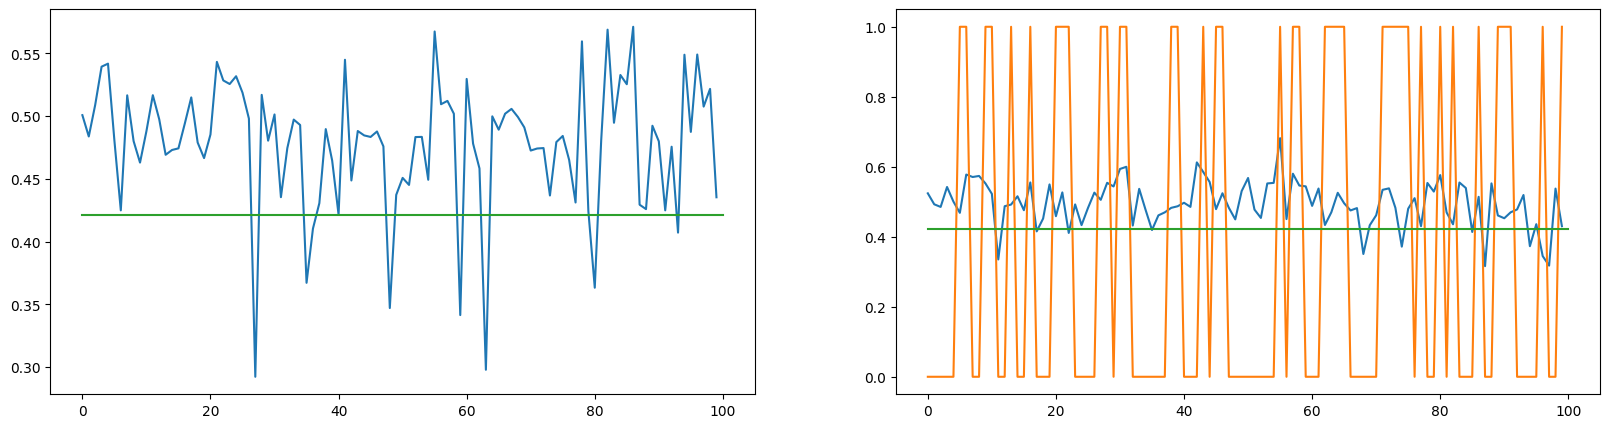

In [10]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100])
plt.plot(y_train[:100])
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100])
plt.plot(y_test[:100])
plt.plot([0, 100], [threshold, threshold])

In [11]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.2109 0.1940 0.2031 0.2160 0.1761


In [12]:
(p_test>threshold).sum()

958

GAZP 2019-05-02T16:00:00.000000000 0.3351962227207105


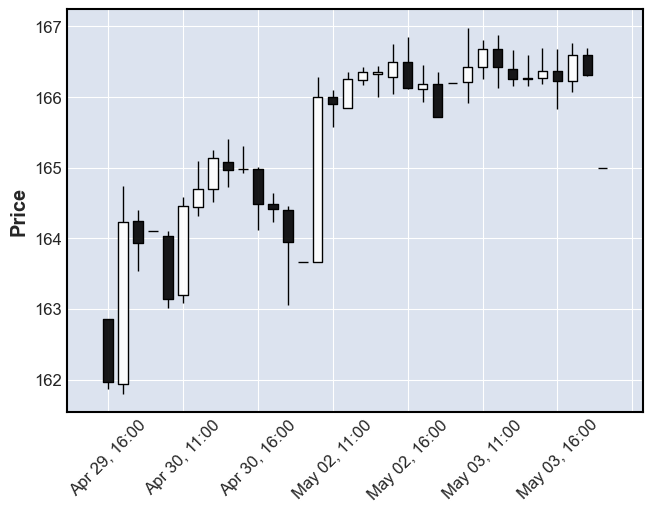

GAZP 2020-05-06T09:00:00.000000000 0.410910476738147


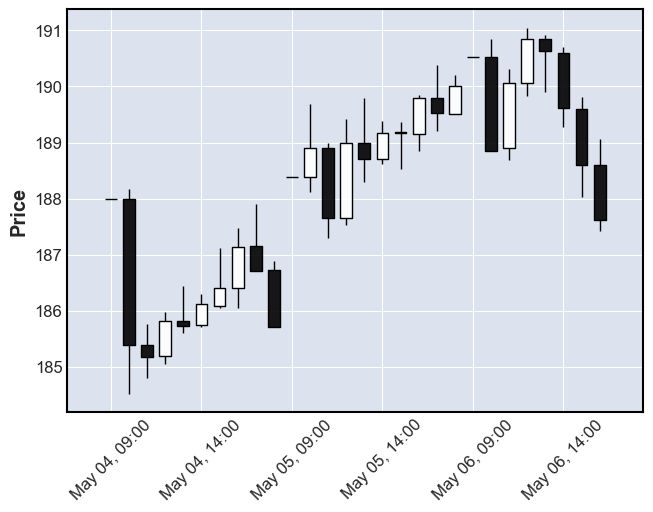

GAZP 2020-05-20T12:00:00.000000000 0.4210537072782033


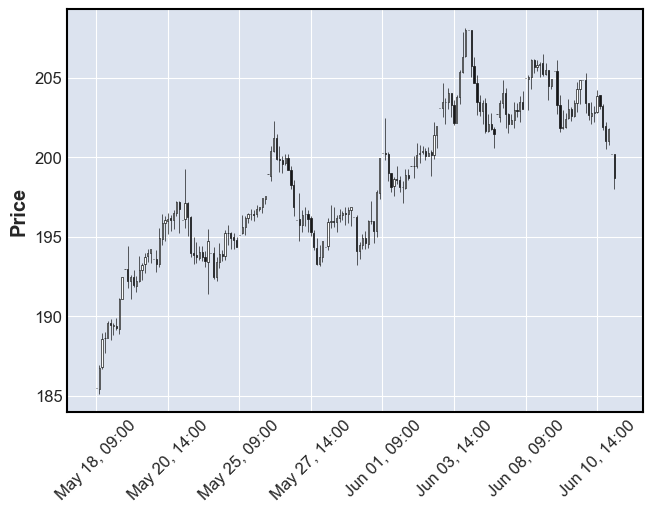

GAZP 2019-05-21T12:00:00.000000000 0.3259227402447524


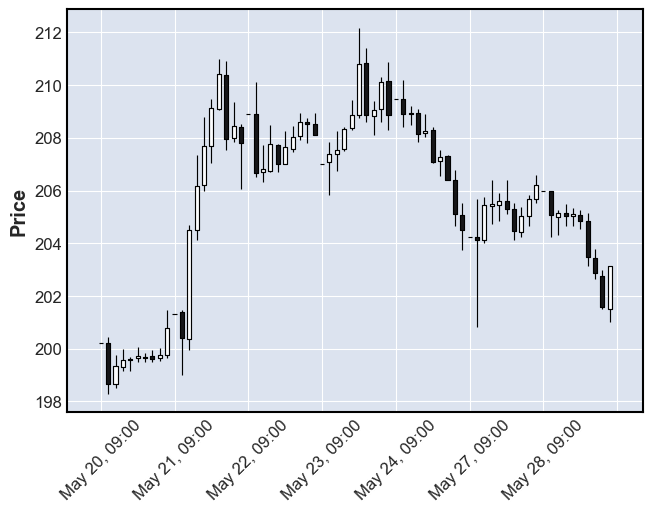

GAZP 2019-01-03T14:00:00.000000000 0.34724194382328555


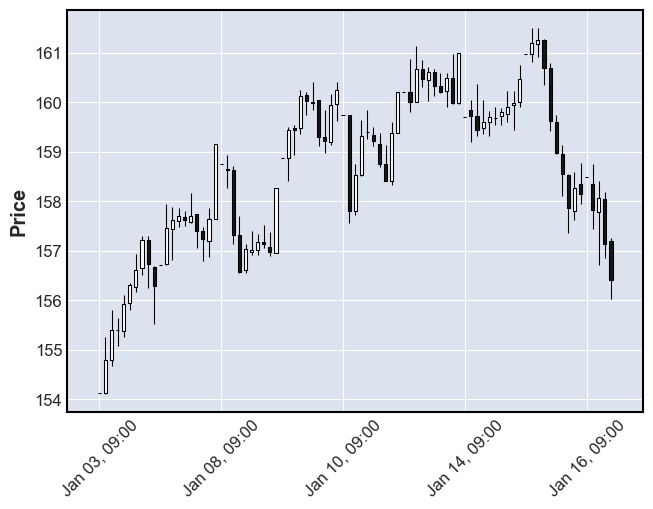

GAZP 2022-07-27T11:00:00.000000000 0.2885932008962699


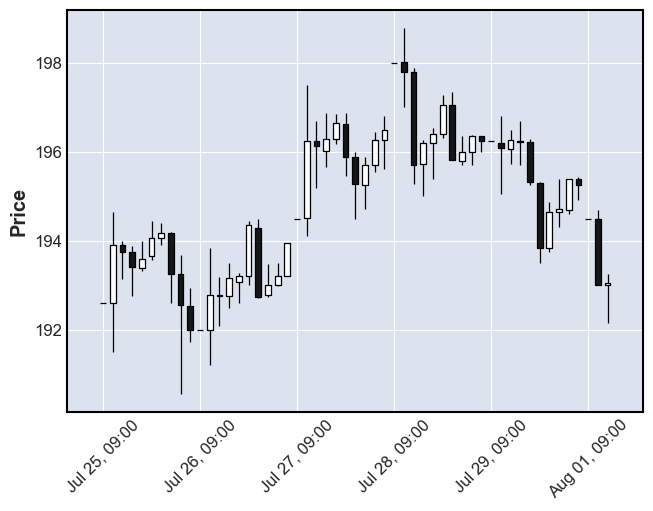

GAZP 2014-01-06T10:00:00.000000000 0.3777901289872856


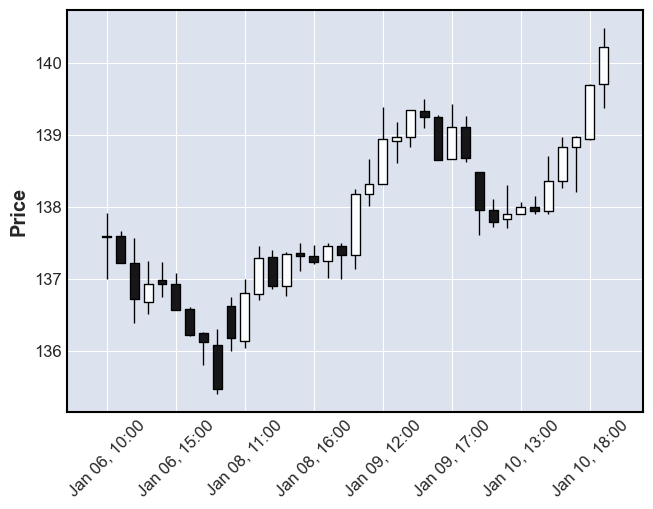

GAZP 2013-03-14T18:00:00.000000000 0.3547598588641218


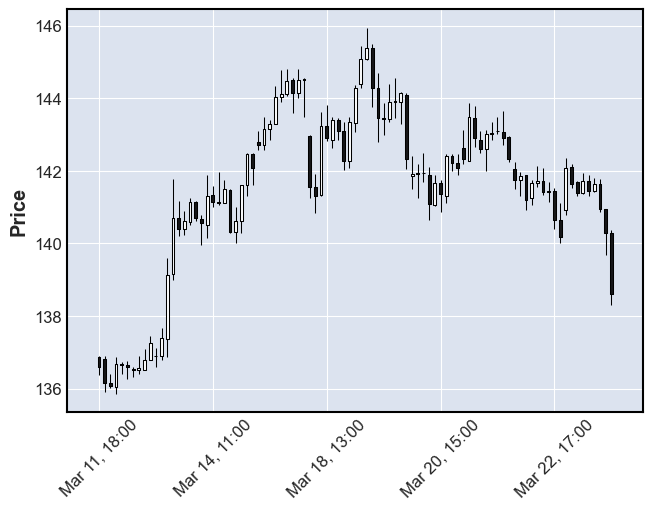

GAZP 2017-04-25T15:00:00.000000000 0.4098660351505876


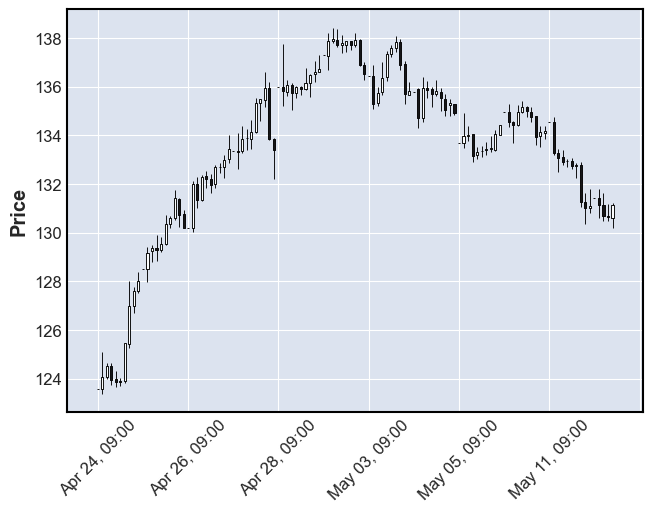

GAZP 2018-01-05T12:00:00.000000000 0.41299431513920076


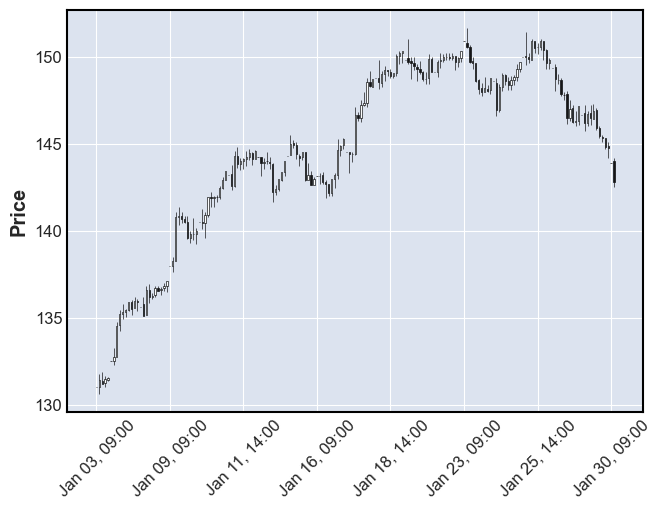

GAZP 2020-07-03T11:00:00.000000000 0.3964316154025392


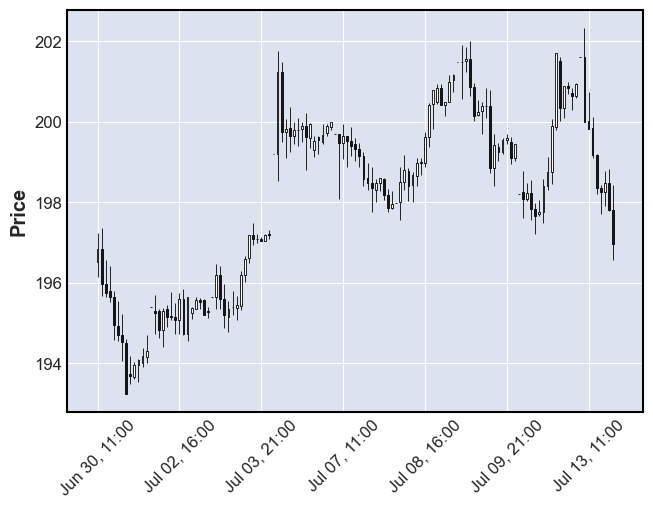

GAZP 2016-06-14T09:00:00.000000000 0.36386958531856506


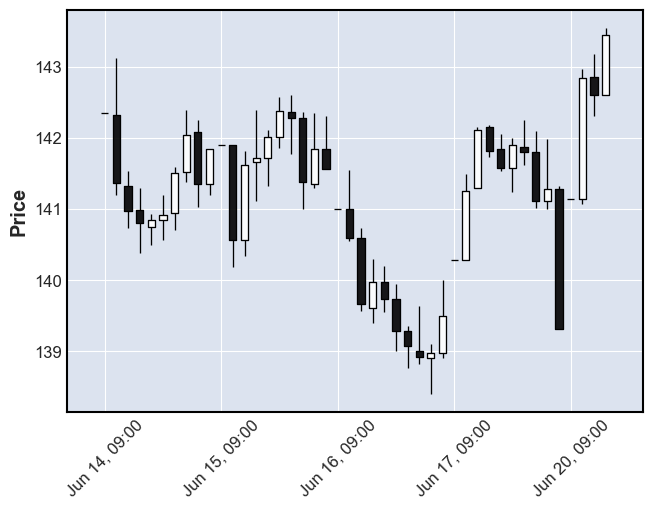

GAZP 2022-07-12T11:00:00.000000000 0.360990289737517


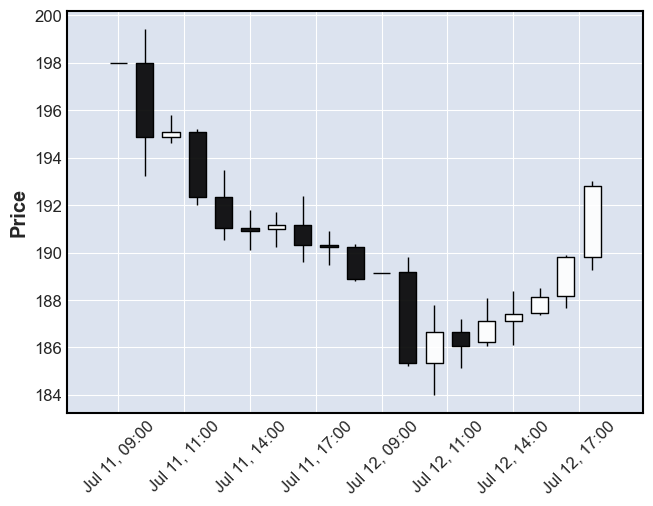

GAZP 2022-08-02T09:00:00.000000000 0.4034325327654171


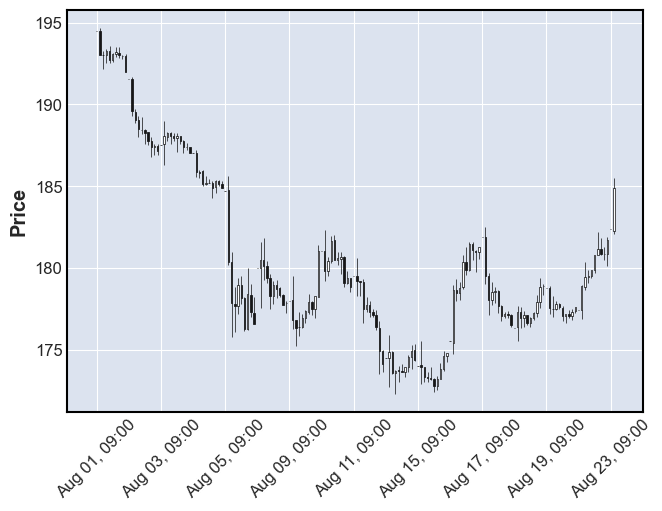

GAZP 2022-04-28T09:00:00.000000000 0.3886987304623478


KeyboardInterrupt: 

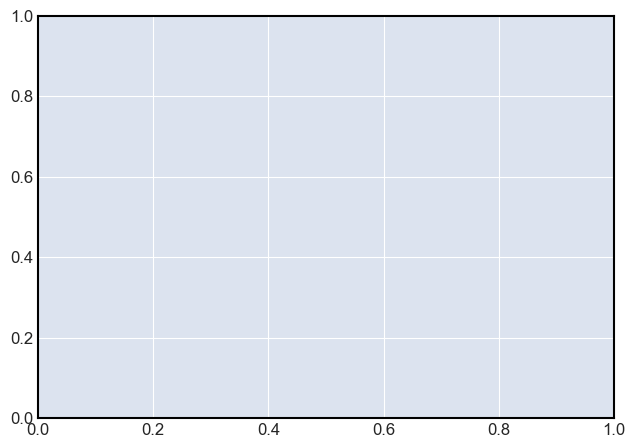

In [13]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [47]:
prediction

array([[0.49287947, 0.50712053]])